<a href="https://colab.research.google.com/github/mathfish/LearningTopics/blob/main/Books/PytorchMastery/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_blobs
import requests
from pathlib import Path

## 1. Make Data

In [ ]:
n_samnples = 1000
X_, y_ = make_circles(n_samples=n_samnples, noise=0.03, random_state=42)

print(f"First 5 samples of X:\n {X_[:5]}")
print(f"First 5 samples of y:\n {y_[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


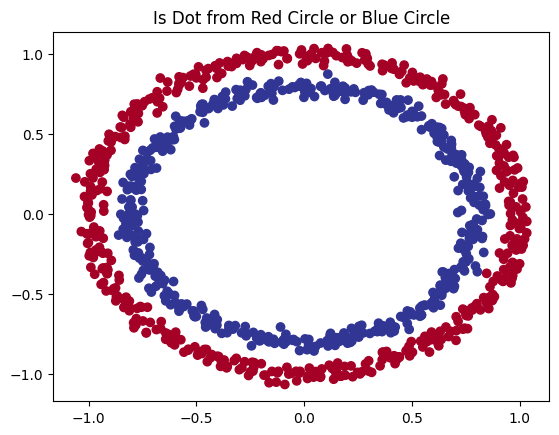

In [ ]:
circles_df = pd.DataFrame({"X1": X_[:, 0], "X2": X_[:, 1]})

plt.scatter(circles_df.X1, circles_df.X2, c=y_, cmap=plt.cm.RdYlBu)
plt.title("Is Dot from Red Circle or Blue Circle");

In [ ]:
# Turn data into tensors and create train and test splits

## change to default data type in pytorch, float32, vs what is numpy, float64
X = torch.from_numpy(X_).type(torch.float)
y = torch.from_numpy(y_).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## 2. Build Classification Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# By hand to create custom model that handle more complex functionality if needed

class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    # create 2 nn linear layers that can handle shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

# model_0 = CircleModelV0().to(device)

torch.manual_seed(42)
# This does the same thing as above. Note raw outputs are logits. Will need to apply sigmoid to get probabilities
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [ ]:
# Setup loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss() # has sigmoid built it whereas BCEWithLoss() requires sigmoid to have been applied but this one is more stable
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [58]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return 100 * (correct / len(y_pred))


## 3. Train Model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

  model_0.train()
  # forward pass
  preds_logits = model_0(X_train).squeeze()
  preds_probs = torch.sigmoid(preds_logits)
  preds_labels = torch.round(preds_probs) # if >= .5 then 1 else 0
  # calc loss
  loss_ = loss_fn(preds_logits, y_train)
  accur_ = accuracy_fn(y_true=y_train, y_pred=preds_labels)
  # zero gradient
  optimizer.zero_grad()
  # back prop
  loss_.backward()
  # gradient
  optimizer.step()

  # predictions
  model_0.eval()
  with torch.inference_mode():
    preds_test_logits = model_0(X_test).squeeze()
    preds_test_probs = torch.sigmoid(preds_test_logits)
    preds_test_labels = torch.round(preds_test_probs)
    loss_test = loss_fn(preds_test_logits, y_test)
    accur_test = accuracy_fn(y_true=y_test, y_pred=preds_test_labels)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss_:.4f} | Train Accuracy: {accur_:.4f} | Test Loss: {loss_test:.4f} | Test ACcuracy: {accur_test:.4f}")

Epoch: 0 | Train Loss: 0.6957 | Train Accuracy: 50.0000 | Test Loss: 0.6972 | Test ACcuracy: 50.0000
Epoch: 10 | Train Loss: 0.6940 | Train Accuracy: 50.0000 | Test Loss: 0.6962 | Test ACcuracy: 50.0000
Epoch: 20 | Train Loss: 0.6934 | Train Accuracy: 46.0000 | Test Loss: 0.6959 | Test ACcuracy: 48.5000
Epoch: 30 | Train Loss: 0.6932 | Train Accuracy: 49.0000 | Test Loss: 0.6958 | Test ACcuracy: 47.5000
Epoch: 40 | Train Loss: 0.6931 | Train Accuracy: 49.5000 | Test Loss: 0.6957 | Test ACcuracy: 46.5000
Epoch: 50 | Train Loss: 0.6931 | Train Accuracy: 50.3750 | Test Loss: 0.6957 | Test ACcuracy: 46.5000
Epoch: 60 | Train Loss: 0.6931 | Train Accuracy: 50.5000 | Test Loss: 0.6956 | Test ACcuracy: 46.5000
Epoch: 70 | Train Loss: 0.6930 | Train Accuracy: 50.5000 | Test Loss: 0.6956 | Test ACcuracy: 46.5000
Epoch: 80 | Train Loss: 0.6930 | Train Accuracy: 50.7500 | Test Loss: 0.6955 | Test ACcuracy: 46.5000
Epoch: 90 | Train Loss: 0.6930 | Train Accuracy: 50.3750 | Test Loss: 0.6955 | Test

## 4. Make Predictions
Model does not seem to be learning. So we need to visualize to investigate


In [7]:


# Download helper functions from Pytorch if not done already

if Path("helpter_functions.py").is_file():
  print("Helper file exists")
else:
  print("Downloading helper functions . . . ")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


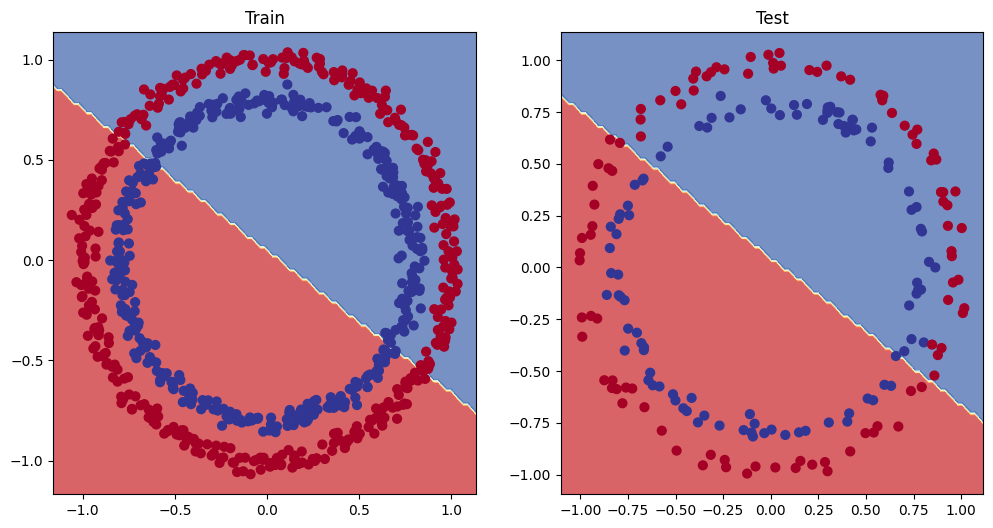

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving the Model
To potentially improve our model we can try:
* Add more layers
* Add more hidden units -> e.g. 5 to 10
* Fit for longer
* Change activation functions
* Change learning rate
* Change loss function

In [ ]:
# Increased the number of hidden units and layers
class CircleModelV1(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # this way leverages speed ups by pytorch
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

In [ ]:
loss_fn_v1 = nn.BCEWithLogitsLoss()
optimizer_v1 = torch.optim.SGD(params=model_1.parameters(), lr=.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  logits_ = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(logits_))

  loss_ = loss_fn_v1(logits_, y_train)
  accur_ = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer_v1.zero_grad()

  loss_.backward()

  optimizer_v1.step()

  model_1.eval()
  with torch.inference_mode():
    y_test_logits = model_1(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    y_test_loss = loss_fn_v1(y_test_logits, y_test)
    y_test_accur = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

  if epoch % 10 == 0:
     print(f"Epoch: {epoch} | Train Loss: {loss_:.4f} | Train Accuracy: {accur_:.4f} | Test Loss: {y_test_loss:.4f} | Test ACcuracy: {y_test_accur:.4f}")


Epoch: 0 | Train Loss: 0.6940 | Train Accuracy: 50.8750 | Test Loss: 0.6926 | Test ACcuracy: 51.0000
Epoch: 10 | Train Loss: 0.6937 | Train Accuracy: 50.2500 | Test Loss: 0.6927 | Test ACcuracy: 50.0000
Epoch: 20 | Train Loss: 0.6935 | Train Accuracy: 50.1250 | Test Loss: 0.6928 | Test ACcuracy: 49.5000
Epoch: 30 | Train Loss: 0.6934 | Train Accuracy: 50.5000 | Test Loss: 0.6930 | Test ACcuracy: 48.0000
Epoch: 40 | Train Loss: 0.6933 | Train Accuracy: 50.3750 | Test Loss: 0.6931 | Test ACcuracy: 49.0000
Epoch: 50 | Train Loss: 0.6932 | Train Accuracy: 49.8750 | Test Loss: 0.6932 | Test ACcuracy: 50.0000
Epoch: 60 | Train Loss: 0.6932 | Train Accuracy: 49.3750 | Test Loss: 0.6934 | Test ACcuracy: 51.5000
Epoch: 70 | Train Loss: 0.6931 | Train Accuracy: 49.3750 | Test Loss: 0.6935 | Test ACcuracy: 50.5000
Epoch: 80 | Train Loss: 0.6931 | Train Accuracy: 50.1250 | Test Loss: 0.6936 | Test ACcuracy: 50.0000
Epoch: 90 | Train Loss: 0.6931 | Train Accuracy: 50.5000 | Test Loss: 0.6937 | Test

## 6. Add Non-linearity



In [ ]:
class CircleModelV2(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)

model_2b = nn.Sequential(
    nn.Linear(in_features=2, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=1),
).to(device)

In [ ]:
loss_fn_v1 = nn.BCEWithLogitsLoss()
optimizer_v1 = torch.optim.SGD(params=model_2b.parameters(), lr=.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_2b.train()
  logits_ = model_2b(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(logits_))

  loss_ = loss_fn_v1(logits_, y_train)
  accur_ = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer_v1.zero_grad()

  loss_.backward()

  optimizer_v1.step()

  model_2b.eval()
  with torch.inference_mode():
    y_test_logits = model_2b(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    y_test_loss = loss_fn_v1(y_test_logits, y_test)
    y_test_accur = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

  if epoch % 100 == 0:
     print(f"Epoch: {epoch} | Train Loss: {loss_:.4f} | Train Accuracy: {accur_:.4f} | Test Loss: {y_test_loss:.4f} | Test ACcuracy: {y_test_accur:.4f}")

Epoch: 0 | Train Loss: 0.6970 | Train Accuracy: 49.0000 | Test Loss: 0.6954 | Test ACcuracy: 48.5000
Epoch: 100 | Train Loss: 0.6710 | Train Accuracy: 76.3750 | Test Loss: 0.6765 | Test ACcuracy: 69.5000
Epoch: 200 | Train Loss: 0.6264 | Train Accuracy: 90.3750 | Test Loss: 0.6382 | Test ACcuracy: 83.5000
Epoch: 300 | Train Loss: 0.5149 | Train Accuracy: 99.7500 | Test Loss: 0.5384 | Test ACcuracy: 98.5000
Epoch: 400 | Train Loss: 0.3228 | Train Accuracy: 100.0000 | Test Loss: 0.3597 | Test ACcuracy: 100.0000
Epoch: 500 | Train Loss: 0.1840 | Train Accuracy: 100.0000 | Test Loss: 0.2211 | Test ACcuracy: 99.5000
Epoch: 600 | Train Loss: 0.0945 | Train Accuracy: 100.0000 | Test Loss: 0.1300 | Test ACcuracy: 100.0000
Epoch: 700 | Train Loss: 0.0592 | Train Accuracy: 100.0000 | Test Loss: 0.0896 | Test ACcuracy: 100.0000
Epoch: 800 | Train Loss: 0.0413 | Train Accuracy: 100.0000 | Test Loss: 0.0679 | Test ACcuracy: 100.0000
Epoch: 900 | Train Loss: 0.0310 | Train Accuracy: 100.0000 | Test 

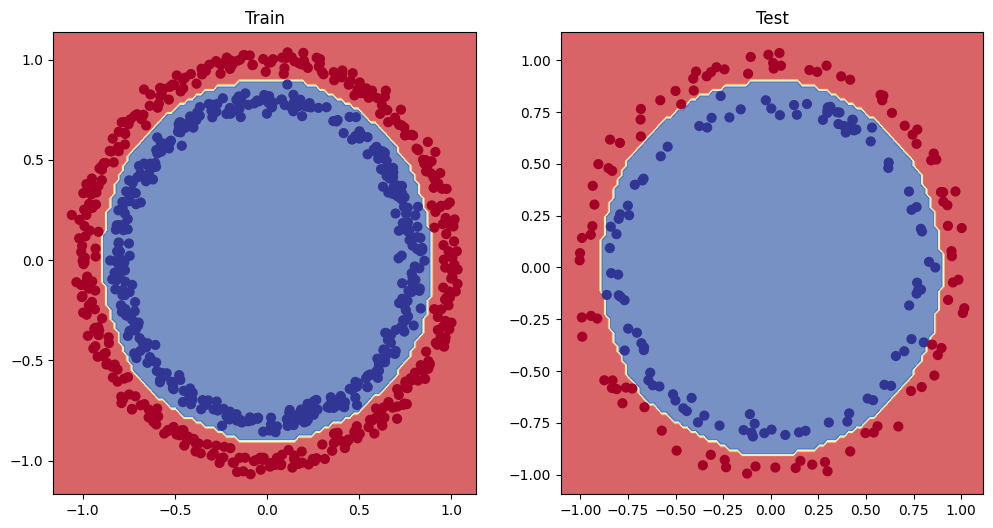

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2b, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2b, X_test, y_test)

## 7. Multiclass Classification |



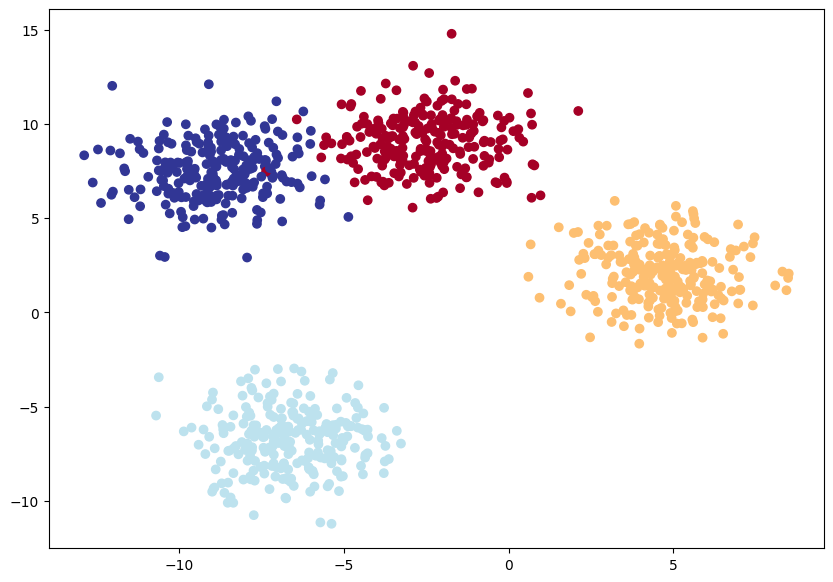

In [70]:
# Create Dataset
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

## Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

## Split into test and train
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [76]:
## Build Model

device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(nn.Module):

  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
      return self.linear_layer_stack(x)


blob_model = BlobModel(input_features=2, output_features=4).to(device)

In [20]:
## check raw output

blob_model.eval()
with torch.inference_mode():
  y_preds = blob_model(X_blob_train.to(device))


# Need to convert from logits -> pred probs -> pred labels
#   Here we have as raw outputs logits. We need an activation function -> softmax
y_preds[:2]

tensor([[ 0.2054,  0.2430, -0.6734,  0.0641],
        [ 0.2467,  0.0703, -0.3355,  0.0992]], device='cuda:0')

In [45]:
samp_logits = torch.softmax(y_preds[:2], dim=1)
print("Sample Logits: ", samp_logits)
samp_labels = torch.argmax(samp_logits, dim=1)
print("Sample Labels: ", samp_labels)

Sample Logits:  tensor([[0.3010, 0.3126, 0.1250, 0.2614],
        [0.3068, 0.2572, 0.1714, 0.2647]], device='cuda:0')
Sample Labels:  tensor([1, 0], device='cuda:0')


In [78]:
## Train Model
torch.manual_seed(42)

epochs = 100
X_train = X_blob_train.to(device)
X_test = X_blob_test.to(device)
y_train = y_blob_train.to(device)
y_test = y_blob_test.to(device)

# Need loss function and optimizer
mc_loss_fn = torch.nn.CrossEntropyLoss()
mc_opt = torch.optim.SGD(params=blob_model.parameters(), lr=0.1)

for epoch in range(epochs):
  blob_model.train()

  # forward pass
  _logits = blob_model(X_train)
  _labels = torch.softmax(_logits, dim=1).argmax(dim=1)

  # calc loss
  loss = mc_loss_fn(_logits, y_train)

  # zero gradient
  blob_model.zero_grad()

  # back prop and update
  loss.backward()
  mc_opt.step()

  if epoch % 10 == 0:
    blob_model.eval()
    with torch.inference_mode():
      logit_out = blob_model(X_test)
      label_out = torch.softmax(logit_out, dim=1).argmax(dim=1)
      loss_out = mc_loss_fn(logit_out, y_test)
      acc_out = accuracy_fn(y_true=y_test, y_pred=label_out)

    print(f"Epoch: {epoch} | Loss: {loss_out:.4f} | Accuracy: {acc_out:.4f}")


Epoch: 0 | Loss: 1.0755 | Accuracy: 48.0000
Epoch: 10 | Loss: 0.6607 | Accuracy: 97.5000
Epoch: 20 | Loss: 0.4307 | Accuracy: 100.0000
Epoch: 30 | Loss: 0.2451 | Accuracy: 99.5000
Epoch: 40 | Loss: 0.1023 | Accuracy: 99.5000
Epoch: 50 | Loss: 0.0585 | Accuracy: 99.5000
Epoch: 60 | Loss: 0.0429 | Accuracy: 99.5000
Epoch: 70 | Loss: 0.0349 | Accuracy: 99.5000
Epoch: 80 | Loss: 0.0299 | Accuracy: 99.5000
Epoch: 90 | Loss: 0.0266 | Accuracy: 99.5000


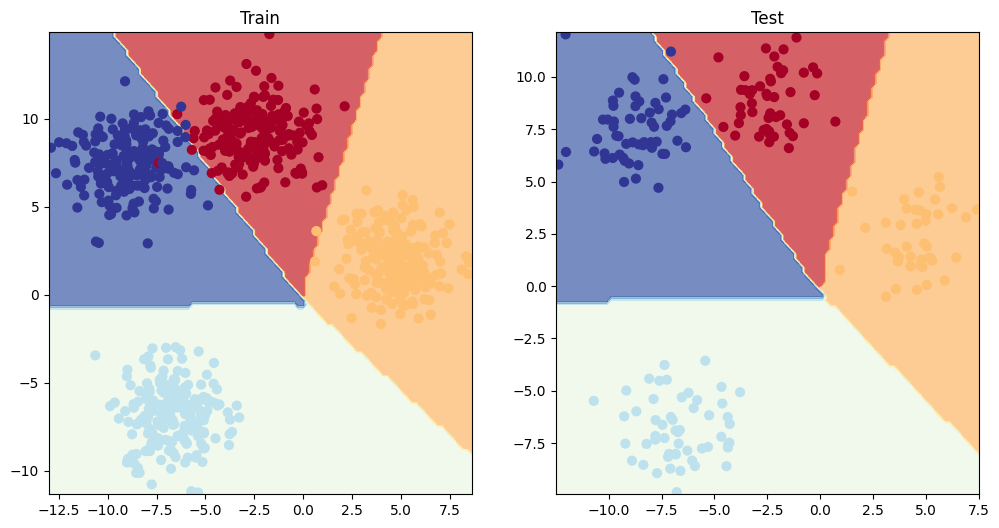

In [66]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_test, y_test)

**Some classification metrics**

Can you use torchmetrics and/or sklearn.metrics

* Accuracy - avoid for imbalanced classes
* Precision
* Recall
* F1
* Confusion matrix
* Classification report



In [81]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [82]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

In [86]:
acc_metric = Accuracy(task='multiclass', num_classes=4).to(device)
acc_metric(label_out, y_test)

tensor(0.9950, device='cuda:0')

In [89]:
rec_metric = Recall(task='multiclass', num_classes=4).to(device)
rec_metric(label_out, y_test)

tensor(0.9950, device='cuda:0')